In [3]:
!pip install tensorflow pandas numpy


Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 7291.2671 - mae: 52.2361 - val_loss: 1206.3129 - val_mae: 20.0162
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 804.5415 - mae: 16.9602 - val_loss: 338.7201 - val_mae: 12.4634
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 273.4587 - mae: 11.1034 - val_loss: 115.9822 - val_mae: 7.4812
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 78.6796 - mae: 6.1653 - val_loss: 34.2506 - val_mae: 3.6542
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32.6031 - mae: 3.7436 - val_loss: 26.2837 - val_mae: 3.3669
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.5757 - mae: 3.3702 - val_loss: 23.5542 - val_mae: 3.3069
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.1328 - mae: 3.2283 - val_loss: 20.6263 - val_mae: 3.1956
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.4338 - mae: 2.9493 - val_loss: 17.0112 - val_mae: 2.8579
Epoch 9/100
136/13

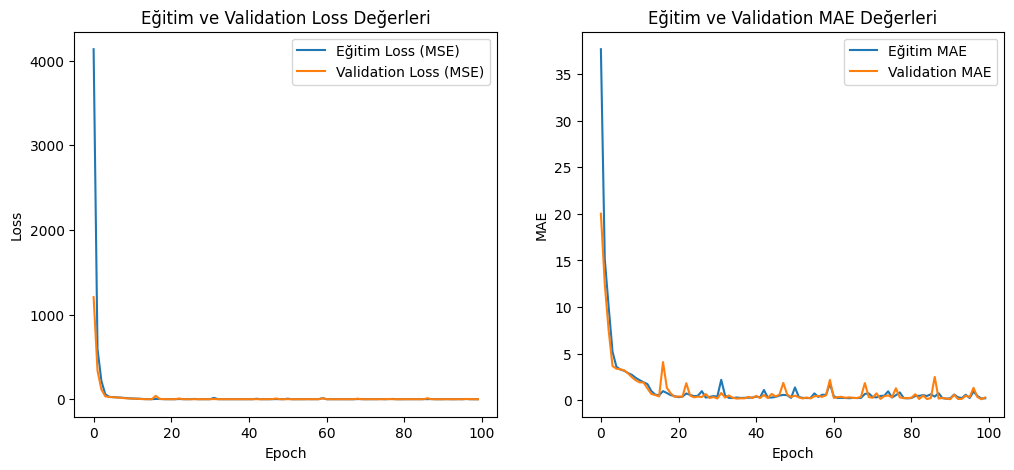

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1606 - mae: 0.2743
Test Loss (Besin Tahmini): 0.16167983412742615
Test MAE (Besin Tahmini): 0.27545416355133057
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model Accuracy (R^2 Score): 0.9950653708742527


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 📌 Kullanıcı veri setini yükle
user_df = pd.read_csv("Final_Updated_User_Dataset.csv")
food_df = pd.read_csv("Food_Dataset.csv")

# 📌 Kullanıcı veri setindeki sütunları temizle
user_df.columns = user_df.columns.str.lower().str.replace(" ", "_")
food_df.columns = food_df.columns.str.lower().str.replace(" ", "_")

# 📌 Hipertansiyon ve diyabet sütunlarını 0/1 formatına çevir
user_df["bpq020"] = user_df["bpq020"].apply(lambda x: 1 if x == 1 else 0)
user_df["diq010"] = user_df["diq010"].apply(lambda x: 1 if x == 1 else 0)

# 📌 Hedef değişkenleri belirle
nutrition_targets = ["protein_(g)", "fat_(g)", "carbs_(g)", "sodium_(mg)"]

# 📌 Kullanıcı özellikleri ve hedef değerler
X = user_df[["riagendr", "ridageyr", "bpq020", "diq010"]].values  # Kullanıcı bilgileri
Y1 = user_df[nutrition_targets].values  # Günlük besin ihtiyacı

# 📌 Eğitim, validation ve test setlerine ayır (70% eğitim, 15% validation, 15% test)
X_train, X_temp, Y1_train, Y1_temp = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_val, X_test, Y1_val, Y1_test = train_test_split(X_temp, Y1_temp, test_size=0.5, random_state=42)

# 📌 Modeli oluştur
input_layer = layers.Input(shape=(4,))
hidden = layers.Dense(128, activation="relu")(input_layer)
hidden = layers.Dense(64, activation="relu")(hidden)
hidden = layers.Dense(32, activation="relu")(hidden)

# 📌 Çıkış 1: Günlük besin ihtiyacı tahmini
nutrition_output = layers.Dense(4, activation="linear", name="nutrition_output")(hidden)

# 📌 Modeli birleştir
model = models.Model(inputs=input_layer, outputs=nutrition_output)

# 📌 Modeli derle
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),  # Öğrenme oranını biraz artırdık
    loss="mse",
    metrics=["mae"]
)

# 📌 Modeli eğit
history = model.fit(
    X_train, Y1_train,
    epochs=100,
    validation_data=(X_val, Y1_val),  # Validation set eklendi!
    verbose=1
)

print("Model Eğitildi! 🚀")

# 📌 Eğitim ve validation sürecini görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Eğitim ve Validation Loss Değerleri")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Eğitim ve Validation MAE Değerleri")
plt.show()

# 📌 Test seti üzerinde modeli değerlendir
test_results = model.evaluate(X_test, Y1_test)
print(f"Test Loss (Besin Tahmini): {test_results[0]}")
print(f"Test MAE (Besin Tahmini): {test_results[1]}")

# 📌 Modelin doğruluğunu (accuracy) ölçme
Y1_pred = model.predict(X_test)
accuracy = r2_score(Y1_test, Y1_pred)  # R^2 skorunu hesapla
print(f"Model Accuracy (R^2 Score): {accuracy}")




In [38]:
# 📌 Modeli test et
new_user = np.array([[1, 60, 0, 1]])  # Yeni kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
predicted_nutrition = model.predict(new_user)[0]
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 Çeşitliliği artırarak yemek seçimi (Çeşitlendirilmiş Greedy Approach)
def recommend_best_meal_diverse(predicted_nutrition, food_df, num_meals=5):
    selected_meals = []
    remaining_nutrition = predicted_nutrition.copy()
    food_df = food_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Yemekleri karıştır
    used_categories = set()

    for _ in range(num_meals):
        food_df["score"] = np.sum(np.abs(food_df[["protein", "fats", "carbs", "sodium"]].values - remaining_nutrition), axis=1)

        # Kategori tekrarını önlemek için farklı kategorilere öncelik ver
        best_food = food_df.loc[~food_df["category_name"].isin(used_categories)].nsmallest(1, "score")

        if best_food.empty:  # Eğer tüm yemekler aynı kategorideyse en düşük skorlu olanı al
            best_food = food_df.nsmallest(1, "score")

        selected_meals.append(best_food["food_name"].values[0])
        used_categories.add(best_food["category_name"].values[0])  # Kategori setine ekle
        remaining_nutrition -= best_food[["protein", "fats", "carbs", "sodium"]].values[0]
        remaining_nutrition = np.maximum(remaining_nutrition, 0)  # Negatif besin değerlerini sıfırla

    return selected_meals

# 📌 En iyi 5 yemeği önerme (Çeşitlendirilmiş yöntem)
recommended_foods = recommend_best_meal_diverse(predicted_nutrition, food_df, num_meals=5)
print(f"Önerilen yemekler: {recommended_foods}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Önerilen günlük besin ihtiyacı: [ 55.779747   64.83246   148.87334     2.2747562]
Önerilen yemekler: ['Sugar', 'Almond butter', 'Yeast', 'Carbonated water', 'Vinegar']


In [29]:
# 📌 Kullanıcı veri setindeki sütunları temizle
user_df.columns = user_df.columns.str.lower().str.replace(" ", "_")
food_df.columns = food_df.columns.str.lower().str.replace(" ", "_")

In [30]:
# 📌 Hipertansiyon ve diyabet sütunlarını 0/1 formatına çevir
user_df["bpq020"] = user_df["bpq020"].apply(lambda x: 1 if x == 1 else 0)
user_df["diq010"] = user_df["diq010"].apply(lambda x: 1 if x == 1 else 0)

In [31]:
# 📌 Hedef değişkenleri belirle
nutrition_targets = ["protein_(g)", "fat_(g)", "carbs_(g)", "sodium_(mg)"]

In [32]:
# 📌 Kullanıcı özellikleri ve hedef değerler
X = user_df[["riagendr", "ridageyr", "bpq020", "diq010"]].values  # Kullanıcı bilgileri
Y1 = user_df[nutrition_targets].values  # Günlük besin ihtiyacı

In [33]:
# 📌 Yemek ID eşleştirmesi
food_df["food_id"] = range(len(food_df))
food_mapping = {row["food_id"]: row["food_name"] for _, row in food_df.iterrows()}

In [34]:
# 📌 Kullanıcı başına rastgele yemek önerisi
np.random.seed(42)
Y2 = np.random.choice(food_df["food_id"].values, size=len(user_df))

In [35]:
# 📌 Eğitim ve test verisini ayır (80% eğitim, 20% test)
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X, Y1, Y2, test_size=0.2, random_state=42)

In [36]:
# 📌 Modeli oluştur
input_layer = layers.Input(shape=(4,))
hidden = layers.Dense(64, activation="relu")(input_layer)
hidden = layers.Dense(32, activation="relu")(hidden)

In [37]:
# 📌 Çıkış 1: Günlük besin ihtiyacı tahmini
nutrition_output = layers.Dense(4, activation="linear", name="nutrition_output")(hidden)

In [38]:
# 📌 Çıkış 2: Yemek önerisi tahmini
food_output = layers.Dense(len(food_df), activation="softmax", name="food_output")(hidden)

In [39]:
# 📌 Modeli birleştir
model = models.Model(inputs=input_layer, outputs=[nutrition_output, food_output])

In [40]:
# 📌 Modeli derle
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss={"nutrition_output": "mse", "food_output": "sparse_categorical_crossentropy"},
    metrics={"nutrition_output": "mae", "food_output": "accuracy"}
)

In [41]:
# 📌 Modeli eğit
history = model.fit(X_train, {"nutrition_output": Y1_train, "food_output": Y2_train}, epochs=100, verbose=1)

print("Model Eğitildi! 🚀")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - food_output_accuracy: 0.0000e+00 - food_output_loss: 7.5767 - loss: 981753.8125 - nutrition_output_loss: 981746.2500 - nutrition_output_mae: 570.5008
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - food_output_accuracy: 0.1250 - food_output_loss: 6.0327 - loss: 973556.9375 - nutrition_output_loss: 973550.8750 - nutrition_output_mae: 567.3912
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - food_output_accuracy: 0.1250 - food_output_loss: 4.7096 - loss: 965653.8125 - nutrition_output_loss: 965649.1250 - nutrition_output_mae: 564.2385
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - food_output_accuracy: 0.1250 - food_output_loss: 3.3793 - loss: 958094.3750 - nutrition_output_loss: 958091.0000 - nutrition_output_mae: 560.8102
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - food_output_accuracy: 0.1250 - food_output_loss: 2.6276 - loss: 950765.8750 - nutrition_output_loss: 950763.2500 - nutrition_output_mae: 556.8287
Epoch 6/

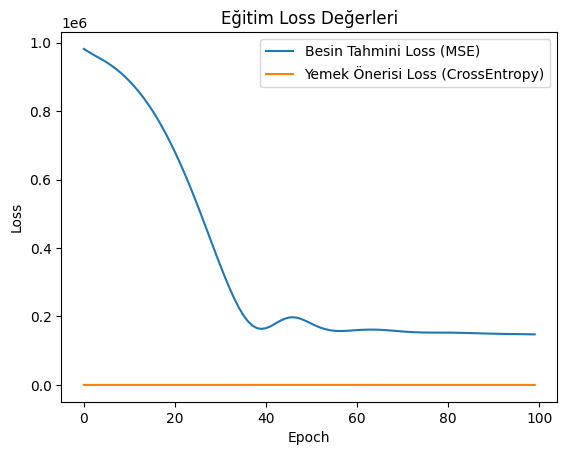

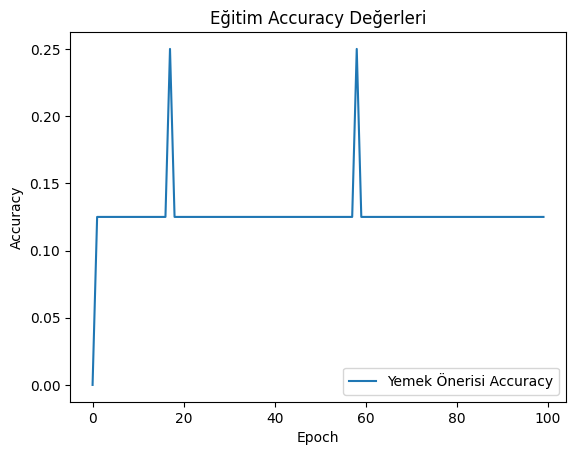

In [42]:
# 📌 Eğitim sürecini görselleştirme
plt.plot(history.history['nutrition_output_loss'], label='Besin Tahmini Loss (MSE)')
plt.plot(history.history['food_output_loss'], label='Yemek Önerisi Loss (CrossEntropy)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Eğitim Loss Değerleri")
plt.show()

plt.plot(history.history['food_output_accuracy'], label='Yemek Önerisi Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Eğitim Accuracy Değerleri")
plt.show()

In [43]:
# 📌 Test seti üzerinde modeli değerlendir
test_results = model.evaluate(X_test, {"nutrition_output": Y1_test, "food_output": Y2_test})
print(f"Test Loss (Besin Tahmini): {test_results[1]}")
print(f"Test MAE (Besin Tahmini): {test_results[2]}")
print(f"Test Loss (Yemek Önerisi): {test_results[3]}")
print(f"Test Accuracy (Yemek Önerisi): {test_results[4]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step - food_output_accuracy: 0.0000e+00 - food_output_loss: 326.6656 - loss: 393619.7188 - nutrition_output_loss: 393293.0625 - nutrition_output_mae: 331.3024
Test Loss (Besin Tahmini): 393293.0625
Test MAE (Besin Tahmini): 326.66558837890625
Test Loss (Yemek Önerisi): 0.0
Test Accuracy (Yemek Önerisi): 331.30242919921875


In [55]:
# 📌 Modeli test et
new_user = np.array([[1, 80, 1, 1]])  # Yeni kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
predicted_nutrition, predicted_food_probs = model.predict(new_user)
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")
recommended_food_index = np.argmax(predicted_food_probs)
recommended_food = food_mapping[recommended_food_index]
print(f"Önerilen yemek: {recommended_food}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Önerilen günlük besin ihtiyacı: [[  67.873726   80.96452   328.13828  2493.116   ]]
Önerilen yemek: Trail mix


In [53]:
# 📌 En iyi 5 yemeği önerme
recommended_food_indices = np.argsort(predicted_food_probs[0])[-5:][::-1]  # En yüksek 5 olasılığı al
recommended_foods = [food_mapping[idx] for idx in recommended_food_indices]
print(f"Önerilen yemekler: {recommended_foods}")

Önerilen yemekler: ['Trail mix', 'Granola bars', 'Cheese popcorn', 'Lucky Charms Cereal', 'Cheeseburger']
